# 0. Theory

From the Subjective Value formula:
# 
$$
SV_{\text{del}}= \frac{V_{\text{del}}}{1 + k\cdot d}
$$
        Where Vdel is the amount to be gained after a (d) delay, SV the subjective value and k the kappa parameter (discount 
        rate).

From this, we can calculate new values for a given SV. 
$$
V = SV \cdot (1+ K \cdot d)
$$

But, most importantly, we take advantage of the fact that, for this model, the only parameter that impacts SV is the delaye. So:
$$
V_{\text{now}} = SV_{\text{now}} 
$$

With this, we can play arround with $V_{\text{now}}$ and $V_{\text{del}}$ (and $SV_{\text{del}}$) to create different trials that symmetrically sample $\triangle SV$ to increase our confidence model fit. 

$$
\triangle SV = SV_{\text{del}} - SV_{\text{now}}

$$
**Meeting 9/21/2023**
- 20 SE trials
- 100 task trials

        - ADO takes approx 20. We can use them wo confidence.
- Garranty that there are trials with maximum delays (90-180 days). Just repeating SVmax if Tmax < 180days 

- Have different Amps for pos and neg SVdiff

# 1. Input

**1.1 In person**

In [18]:

import csv
import os

##The following lines search an individual participant kappa value. We can just modify the end to make it compatible with ADO 
#participant_code = input ("")
path = '/Volumes/UCDN/datasets/SDM/'
#path = 'Z:/datasets/SDM/' #Laptop path
participant_code = '23_SDM_0004_N'
print('the Participant Code is ' + participant_code)
#MAC path to the File share
participant_split_dir = os.path.join(path,'split') 
participant_trials = os.path.join(participant_split_dir,'{}/cdd/{}_cdd.csv').format(participant_code,participant_code) #This is the psychopy output CSV.We will use it to retrieve the probabilities and image files. 

#Path to the utility model data
utility_dir = os.path.join(path,'utility')
utility_analysis = os.path.join(utility_dir,'split_CDD_analysis.csv')

print('loading fn: {}'.format(participant_trials))
print('loading fn: {}'.format(utility_analysis))

#Extracting the parameters from participants

#Initialize kappa variable
kappa_value = None

# Open the CSV file and read its contents into csv_data
def get_kappa_value(utility_analysis):
    with open(utility_analysis, newline='') as file:
        reader = csv.DictReader(file)
    # Iterate through each row in the CSV
        for row in reader:
            if row['subject'] == participant_code:
                kappa_value = float(row['kappa'])
                break  # Exit the loop once the participant is found
    
    return kappa_value

kappa_value = get_kappa_value(utility_analysis)
#kappa_value = 0.1234 # impatient/impulsive
kappa_value = 0.432 # patient
print ('kappa_value',kappa_value)

the Participant Code is 23_SDM_0004_N
loading fn: /Volumes/UCDN/datasets/SDM/split/23_SDM_0004_N/cdd/23_SDM_0004_N_cdd.csv
loading fn: /Volumes/UCDN/datasets/SDM/utility/split_CDD_analysis.csv
kappa_value 0.432


**1.2: ADO**

In [19]:
#kappa_value = post_mean_cdd[0] #parameters for gains

# 2. Money and time options.
Parameters variables

In [20]:
#Declare the values of immediate values, delayed values, and wait times that we are going to use

amt_immed_options = [2, 5, 10, 15, 18, 20, 27, 30, 34, 35, 41, 43, 44, 47, 51, 62, 63, 64]
amt_del_options= [5.0,10.0, 20.0, 35.0, 50.0, 65.0] #Possible immediate options

V_max= 65.0 #Maximum pay
V_min = 2.0 #Minimum pay
max_time = 180 #Longest delay
min_time = 2 #shortest delay 

#Parameter to modulate how many intermediate trials we want

Amp = 1/5.0 #The fraction of SVmax to match the final time_option
if kappa_value < 0.003:
    Amp = 1/4.0

#Calculate the time options
num_steps = 5 #How many delayed options we want

#Longest possible delay to sample from to equally sample SVdelta pos and neg

d0 = (1/Amp -1)/kappa_value 
if d0 > max_time: 
    d0 = max_time #To ensure 180 days is the max limit for peopke with low kappa_value

#Initialize the time_options_1 list with time options that we want always to be present
time_options_1 = [7,15]

if d0 < max_time:
    num_steps = 3
    time_options_1 += [d0+((max_time-d0)/2),max_time] #To ensure that the longest delays are always included for participant's with high kappa

#loop through the number of time_options (num_steps)

for i in range(num_steps+1):
    if i >0:
        time_options_1.append(i*(d0/num_steps)) 
    else:
        time_options_1.append(min_time)

time_options = []
for t in time_options_1:
    time_options += [int(t)]


#print('amt_immed_options',sorted(amt_immed_options))
print('amt_del_options',sorted(amt_del_options))
print('time_options',sorted(time_options))

amt_del_options [5.0, 10.0, 20.0, 35.0, 50.0, 65.0]
time_options [2, 3, 6, 7, 9, 15, 94, 180]


# 3. Functions

General useful functions

In [21]:

#To keep the dictionaries in order
keys_order = ['category', 'cdd_immed_amt', 'cdd_delay_amt', 'cdd_delay_wait', 'delay_SV', 'deltaSV']
def order_keys(dict, keys_order):
    ordered_dict = {}
    for key in keys_order:
        if key in dict:
            ordered_dict[key] = dict[key]
    return ordered_dict

#To unpack nested lsits
def flatten(lst):
    """Flatten a list of lists."""
    return [item for sublist in lst for item in sublist]


def round_to_closest_half(number):
    rounded_number = round(number * 2) / 2
    return 0.5 if rounded_number == 0 else rounded_number


#Our own zip function to ease javascript translation
def zippy(x, y):
    zipper = []
    for i in range(len(x)):
        zipper.append({'x':x[i], 'y':y[i]})
    return zipper


#Our own enumerate function to ease javascript translation
def mighty_numeration(iterable, start=0):
    n = start
    for elem in iterable:
        yield n, elem
        n += 1
        
def value_repeat(value,length):
    list_repeat = []
    for i in range(length):
        list_repeat = list_repeat + [value]
    return list_repeat 



Trials functions

In [22]:
#This function adds SV and delta SV to a trials dictionary
def add_SV(trials, kappa_value): 
    """
    Adds SV and delta SV to a trials dictionary
    """
    trials['delay_SV'] = []
    trials['deltaSV'] = []
    zip_data = zippy(trials['cdd_delay_amt'], trials['cdd_delay_wait'])
    for data in zip_data:
        v = data['x']
        D = data['y']
        trials['delay_SV'].append((v)/(1+kappa_value*D))

    zip_data2 = zippy(trials['delay_SV'], trials['cdd_immed_amt'])
    for data2 in zip_data2:
        svdel = data2['x']
        svimmed = data2['y']
        trials['deltaSV'].append(svdel - svimmed)
        
    return trials


def get_SE(kappa_value, amt_del_options, time_options): 
    """
    Creates the trials of subjective equality.
    Inputs:
        - kappa_value.
        - amt_del_options: List of delayed amounts.
        - time_options: List of delay times.
    Output:
        - SE_trials: A dictionary containing immediate options with the same subjective value as delayed options.
    """ 
    SE_trials = {'category':[],'cdd_delay_wait':[],'cdd_immed_amt':[],'cdd_delay_amt':[]}
    amt_del_options= [5.0, 20.0, 40.0]
    for D in time_options:
        cdd_immed_amt_for_D = []
        for v in amt_del_options:
            cdd_immed_amt_for_D.append(round_to_closest_half(v / (1 + kappa_value * D)))
        SE_trials['cdd_immed_amt'].extend(cdd_immed_amt_for_D)
        SE_trials['cdd_delay_amt'].extend(amt_del_options)
        SE_trials['cdd_delay_wait'].extend(value_repeat(D, len(amt_del_options)))
        #SE_trials['cdd_delay_wait'].extend([D] * len(amt_del_options))
        
    #SE_trials['category'] = ['SE_trials']* len(SE_trials['cdd_immed_amt'])
    SE_trials['category'] = value_repeat('SE_trials', len(SE_trials['cdd_immed_amt']))
    
    return SE_trials

def max_neg_delta(kappa_value, amt_immed_options, amt_del_options, time_options):
    """
    Creates trials with the maximum negative delta subjective value (SV), that are not catch trials (Vdel > Vn).
    """
    min_SV_trials = {'category':[],'cdd_delay_wait':[],'cdd_immed_amt':[],'cdd_delay_amt':[],'deltaSV':[]}
    for d in time_options:
        #Initialize local variables
        SV_diff = 0
        ivn = 0  
        ivl = 0  
        for vn in amt_immed_options:
            for vl in amt_del_options:
                if vl <= vn:
                    continue
                iSV_diff = (vl / (1+kappa_value*d)) - vn
                if iSV_diff < SV_diff:
                    SV_diff = iSV_diff
                    ivn,ivl = vn,vl
        min_SV_trials['category'].append('minSV')
        min_SV_trials['cdd_delay_wait'].append(d)
        min_SV_trials['cdd_immed_amt'].append(ivn)
        min_SV_trials['cdd_delay_amt'].append(ivl)
        min_SV_trials['deltaSV'].append(SV_diff)
    return min_SV_trials


In [23]:
#Subjective equality trials
SE_trials = get_SE(kappa_value,amt_del_options, time_options)
SE_trials = add_SV(SE_trials, kappa_value)
SE_trials = order_keys(SE_trials,keys_order)


#Maximum neg delta without having catch trials
min_trials = max_neg_delta(kappa_value, amt_immed_options, amt_del_options, time_options)
#And, to have them 2 times
min_SV_trials = {}
for key in min_trials:
    min_SV_trials[key] = min_trials[key] + min_trials[key] #To double the lenth of the Max SVdelta trials

min_SV_trials = add_SV(min_SV_trials, kappa_value)
min_SV_trials = order_keys(min_SV_trials,keys_order)


Knowing the biggest negative delta, we can calculate the positive

In [24]:
def target_SVdiff(min_SV_trials,Vmax = V_max,Amp = Amp): 
    """
    Defines the target SV_deltas we want to sample given the SV range. 
    """
    sv_deltas = []
    for delta_sv in min_SV_trials['deltaSV']:
        sv_deltas.append(delta_sv) 
    min_sv_diff = min(sv_deltas)
    SV_range_pos = []
    SV_range_neg = []
    for g in range(int(1/Amp)): 
        if g!=0:
            SV_range_pos.append(Amp*Vmax*g) 
            SV_range_neg.append(Amp*min_sv_diff*g) 

    return SV_range_pos , SV_range_neg

target_SV_deltas_pos, target_SV_deltas_neg  = target_SVdiff(min_SV_trials)


In [25]:

def get_int_pos_SV_delta(target_SV_deltas,amt_immed_options, time_options, Vmax= V_max, valence = 'pos'):

    max_sv_trials = {'category':[],'cdd_delay_wait':[],'cdd_immed_amt':[],'cdd_delay_amt':[]}
    Vimm = min(amt_immed_options)
    category = 'Int+'
    if valence == 'neg':
        Vimm = 10.0 #max(amt_immed_options)
        category = 'Int-'
    for index, delta_sv in mighty_numeration(target_SV_deltas, start=1):
        category_value = index
        for D in time_options:
            Vdel = [round_to_closest_half((delta_sv+Vimm)*(1 + kappa_value*D))]
            for v in Vdel:
                if v <= Vmax:
                    max_sv_trials['cdd_delay_amt'].append(v)
                    max_sv_trials['cdd_delay_wait'].append(D)
                    max_sv_trials['cdd_immed_amt'].append(Vimm)
                    max_sv_trials['category'].append(category + str(category_value))
    return max_sv_trials


Int_pos = get_int_pos_SV_delta(target_SV_deltas_pos,amt_immed_options, time_options)
Int_pos = add_SV(Int_pos, kappa_value)
Int_pos = order_keys(Int_pos,keys_order)


In [26]:
def get_int_neg_SV_delta(target_SV_deltas,amt_immed_options, time_options, Vmax = V_max, d0 = 180, valence = 'pos'):

    max_sv_trials = {'category':[],'cdd_delay_wait':[],'cdd_immed_amt':[],'cdd_delay_amt':[]}
    Vimm = max(amt_immed_options)
    category = 'Int+'
    if valence == 'neg':
        Vdel = 65.0
        category = 'Int-'
    for index, delta_sv in mighty_numeration(target_SV_deltas, start=1):
        category_value = index
        for D in time_options:
            if D>d0:
                continue
            Vimm = round_to_closest_half((Vdel)/(1 + kappa_value*D)-delta_sv)
            #for v in Vdel:
            if Vimm > Vdel:
                continue
            max_sv_trials['cdd_delay_amt'].append(Vdel)
            max_sv_trials['cdd_delay_wait'].append(D)
            max_sv_trials['cdd_immed_amt'].append(Vimm)
            max_sv_trials['category'].append(category + str(category_value))
    return max_sv_trials


Int_neg = get_int_neg_SV_delta(target_SV_deltas_neg, amt_immed_options, time_options, d0 = d0, valence='neg')
Int_neg = add_SV(Int_neg, kappa_value)
Int_neg = order_keys(Int_neg,keys_order)


In [27]:
def get_Max_SVdelta(time_options, Vmax=V_max, Vmin=V_min):
    """
    This function creates the trials with the Maximum Positive delta. 
    By assigning the largest amount we can pay to the delayed options and the least we can pay to the immediate options
    """
    
    Max_SVdelta = {'category':['MaxSV'],'cdd_delay_wait':[2],'cdd_immed_amt':[2.0],'cdd_delay_amt':[65.0]}
    Max_SVdelta['category'].extend(['MaxSV']*len(time_options))
    Max_SVdelta['cdd_delay_amt'].extend([Vmax]*len(time_options))
    Max_SVdelta['cdd_immed_amt'].extend([Vmin]*len(time_options))
    # Set cdd_delay_wait
    Max_SVdelta['cdd_delay_wait'].extend(time_options)
    return Max_SVdelta


Max_trials = get_Max_SVdelta(time_options)

Max_SV_trials = {}
for key in Max_trials:
    Max_SV_trials[key] = Max_trials[key] + Max_trials[key]

Max_SV_trials = add_SV(Max_SV_trials, kappa_value)
Max_SV_trials = order_keys(Max_SV_trials,keys_order)



# Output CSV

In [28]:
def dict_merge(list_dict):
   merged_dict = list_dict[0].copy()
   for d in list_dict[1:]:
     for key, value in  d.items():
        merged_dict[key] = merged_dict[key] + value      
   return merged_dict


trials = dict_merge([Max_SV_trials, Int_pos, SE_trials, Int_neg, min_SV_trials])
trials['cdd_immed_wait'] = [0]*len(trials['category'])
keys_order = ['category', 'cdd_immed_amt','cdd_immed_wait' ,'cdd_delay_amt', 'cdd_delay_wait', 'delay_SV', 'deltaSV']
trials = order_keys(trials, keys_order)



In [29]:

def length_int_trials(trials, valence = '+'):
   category = list(trials['category'])
   int_category = []
   length_int_trials = 0
   for c in category:  
      if valence in c:
         int_category += [c]
         length_int_trials += 1
   return length_int_trials

def needed_categories(trials, valence = '+'):
   category = list(set(trials['category']))
   int_category = [] 
   for c in category:  
      if valence in c:
         int_category += [c]
   return int_category


def grab_additional_trial(trials,c,r):
   for trial_idx,trial_category in enumerate(trials['category']):
      if trial_category==c:
         additional_trial = {'category': ['{}_repeat'.format(c)],
                              'cdd_immed_amt' : [trials['cdd_immed_amt'][trial_idx]],
                              'cdd_immed_wait' : [trials['cdd_immed_wait'][trial_idx]],
                              'cdd_delay_amt' : [trials['cdd_delay_amt'][trial_idx]],
                              'cdd_delay_wait': [trials['cdd_delay_wait'][trial_idx]],
                              'delay_SV' : [trials['delay_SV'][trial_idx]],
                              'deltaSV': [trials['deltaSV'][trial_idx]]
                              }
         # print('Number of repeats: {}'.format(r))
         r = r-1
         if r>0:
            continue
         return additional_trial
         # trials


def add_trials(trials, trials_needed, valence = '+'):
   int_category = needed_categories(trials, valence= valence)
   nb_repeats = 1
   if len(int_category) < trials_needed:
      nb_repeats = int(trials_needed / len(int_category))
   
   for r in range(nb_repeats):
      for c in int_category:
         if trials_needed == 0:
            return trials
         additional_trial = grab_additional_trial(trials,c,r)
         if additional_trial is None:
            additional_trial = grab_additional_trial(trials,c,1)   
         trials = dict_merge([trials,additional_trial])
         trials_needed = trials_needed-1
         
   return trials


def standard_trial_number(trials,desired_trials):
   trials_needed = desired_trials - len(trials['category'])
   length_pos = length_int_trials(trials, valence='+')
   length_neg = length_int_trials(trials, valence='-')
   int_diff = length_pos - length_neg
   print('(trials_needed,len_Int_pos,len_Int_neg) : ({},{},{})'.format(trials_needed,length_pos,length_neg))
   # sys.exit()
   if abs(int_diff) < trials_needed:
      print('Were doomed')
      trials_gap = trials_needed - abs(int_diff)
      if int_diff<0:
         # add more positives, few negatives
         trials_needed_pos = trials_gap + (trials_needed-trials_gap)/2
         trials = add_trials(trials, trials_needed_pos, valence='+')
         trials_needed_neg = (trials_needed-trials_gap)/2
         trials = add_trials(trials, trials_needed_neg, valence='-')
      else:
         # add more negatives, few positives
         trials_needed_neg = trials_gap + (trials_needed-trials_gap)/2
         trials = add_trials(trials, trials_needed_neg, valence='-')
         trials_needed_pos = (trials_needed-trials_gap)/2
         trials = add_trials(trials, trials_needed_pos, valence='+')



   elif int_diff > 0:
      # need to add trials from int_neg
      trials = add_trials(trials, trials_needed, valence='-')
   else: 
      trials = add_trials(trials, trials_needed, valence='+')

   return trials


desired_trials = 100
trials = standard_trial_number(trials,desired_trials)

(trials_needed,len_Int_pos,len_Int_neg) : (22,6,14)
Were doomed


In [30]:
final_trials = trials.copy()
#Drop subjective value and deltaSv columns
keys_order_final = ['cdd_immed_amt','cdd_immed_wait' ,'cdd_delay_amt', 'cdd_delay_wait']
final_trials = order_keys(final_trials, keys_order_final)



In [31]:
output_file_path = 'cdd_csv/{}_ApativeCDD.csv'.format(participant_code)  # Replace with the desired output file path

def get_element_by_col(my_dict,row_nb):
    row_dict=dict.fromkeys(my_dict.keys())
    for c in my_dict.keys():
        row_dict[c] = my_dict[c][row_nb]
    return row_dict

def convert_list_dict(my_dict):
    my_list_dict = []
    nb_trials = len(my_dict[next(iter(my_dict))])
    for row_nb in range(nb_trials):
        row_dict = dict.fromkeys(my_dict.keys())
        row_dict = get_element_by_col(my_dict,row_nb)
        my_list_dict += [row_dict]
    return my_list_dict


list_dict = convert_list_dict(final_trials)
def save_to_csv(cdd_trials,fn= output_file_path):
    cdd_trials_list = convert_list_dict(cdd_trials)
    
    print('Saving to : {}'.format(fn))
    # Open a file in write mode.
    with open(fn, 'w') as f:
        # Write all the dictionary keys in a file with commas separated.
        keys = list(cdd_trials_list[0].keys())
        f.write(','.join(cdd_trials_list[0].keys()))
        f.write('\n') # Add a new line
        for row in cdd_trials_list:
            values = []
            for key in keys:
                values.append(str(row[key]))
            # Write the values in a row.
            f.write(','.join(values))
            f.write('\n')  # Add a new lin

cdd_trials = save_to_csv(final_trials,fn= output_file_path)


Saving to : cdd_csv/23_SDM_0004_N_ApativeCDD.csv


# Visualization

In [32]:
import pandas as pd

pd.options.display.max_rows = 999
# Convert the dictionary to a DataFrame and set 'category' as index
df_trials = pd.DataFrame(trials)
col_order =['category', 'cdd_immed_amt', 'cdd_immed_wait', 'cdd_delay_amt', 'cdd_delay_wait', 'delay_SV', 'deltaSV']
df_trials = df_trials[col_order]
#df_trials['category'] = df_trials.apply(lambda row: f'Int+{6 - int(row["category"].split("+")[1])}' if 'Int+' in row['category'] else row['category'], axis=1)

#df_trials['catch_trials'] = df_trials['cdd_immed_amt'] > df_trials['cdd_delay_amt']
#df_trials = df_trials.sort_values(by = ['deltaSV'])
df_trials

,category,cdd_immed_amt,cdd_immed_wait,cdd_delay_amt,cdd_delay_wait,delay_SV,deltaSV
0,MaxSV,2.0,0,65.0,2,34.871245,32.871245
1,MaxSV,2.0,0,65.0,7,16.153082,14.153082
2,MaxSV,2.0,0,65.0,15,8.689840,6.689840
3,MaxSV,2.0,0,65.0,94,1.562200,-0.437800
4,MaxSV,2.0,0,65.0,180,0.825292,-1.174708
5,MaxSV,2.0,0,65.0,2,34.871245,32.871245
6,MaxSV,2.0,0,65.0,3,28.310105,26.310105
7,MaxSV,2.0,0,65.0,6,18.095768,16.095768
8,MaxSV,2.0,0,65.0,9,13.297872,11.297872
9,MaxSV,2.0,0,65.0,2,34.871245,32.871245


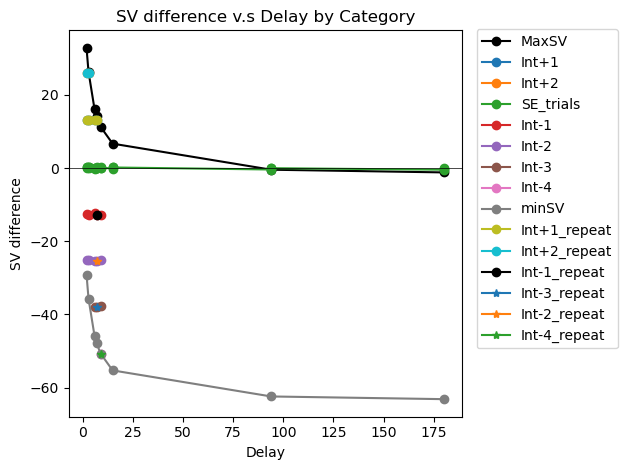

In [33]:
import matplotlib.pyplot as plt

def plot_scatter_by_category(df):
    # Get unique categories and assign a color to each category
    categories = df['category'].unique()
    
    # Assigning black (RGB: 0, 0, 0) as the first color
    colors = [(0.0, 0.0, 0.0)] + list(plt.cm.tab10.colors[:len(categories) - 1])
    
    # If there are more than 10 categories, repeat the colors
    if len(categories) > 10:
        colors = colors * (len(categories) // 10 + 1)
    
    # Create a scatter plot for each category with a different color
    for i, category in mighty_numeration(categories):
        category_data = df[df['category'] == category]
        marker = 'o-'
        if i>11:
            marker = '*-'
        x,y = category_data['cdd_delay_wait'].to_list(), category_data['deltaSV'].to_list()    
        x,y = zip(*sorted(set(zip(x,y))))
        plt.plot(x,y, marker, label=category, color=colors[i])

    # Add labels and legend
    plt.xlabel('Delay')
    plt.ylabel('SV difference')
    plt.title('SV difference v.s Delay by Category')
    #plt.axvline(x=70, color='red', linestyle='--', label='xvline=70')
    plt.axhline(y=0, color='black', linewidth=0.5)
    # Move the legend outside the plot to the right
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.021))
    plt.tight_layout()
    plt.show()

# Plot scatter plot with different colors for each category
plot_scatter_by_category(df_trials)

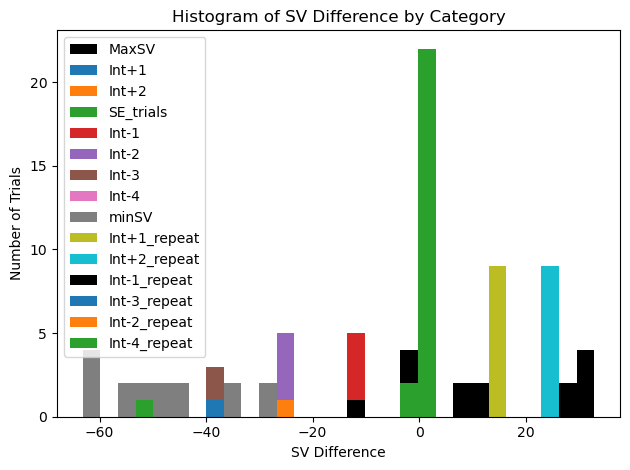

In [34]:
import numpy as np

def plot_histogram_by_category(df):
    # Get unique categories and assign a color to each category
    # Get unique categories and assign a color to each category
    categories = df['category'].unique()
    
    # Assigning black (RGB: 0, 0, 0) as the first color
    colors = [(0.0, 0.0, 0.0)] + list(plt.cm.tab10.colors[:len(categories) - 1])
    
    # If there are more than 10 categories, repeat the colors
    if len(categories) > 10:
        colors = colors * (len(categories) // 10 + 1) 

    # Determine bin edges
    bin_edges = np.linspace(min(df['deltaSV']), max(df['deltaSV']), 30)  # 20 bins from 0 to maximum deltaSV

    # Create a histogram for SV difference for each category with a different color
    for i, category in enumerate(categories):
        category_data = df[df['category'] == category]
        plt.hist(category_data['deltaSV'], bins=bin_edges, alpha=1, label=category, color=colors[i], stacked=True)

    # Add labels and legend
    plt.xlabel('SV Difference')
    plt.ylabel('Number of Trials')
    plt.title('Histogram of SV Difference by Category')
    #plt.axvline(x=0, color='red', linestyle='--', label='Zero SV Difference')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot histogram with different colors for each category
plot_histogram_by_category(df_trials)

![Alt text](https://media.tenor.com/sl9LOXQe9OMAAAAC/this-is-madness-300.gif)